# Train

In [18]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'lib'))

from train import parse_config, get_features, print_model_to_json

In [19]:
from keras.optimizers import Adam, Nadam
from callbacks import all_callbacks

In [22]:

from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel")

options = Option(
    inputModel = '../KERAS_lstm_model_weights.h5',
    inputFile = '../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = '../train/train_config_lstm.yml',
    jsonModel = '../KERAS_lstm_model.json'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)

yamlConfig

Loading configuration from ../train/train_config_lstm.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [23]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [24]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.load_weights(options.inputModel)
model.summary()
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

callbacks=all_callbacks(stop_patience=1000, 
                        lr_factor=0.5,
                        lr_patience=10,
                        lr_epsilon=0.000001, 
                        lr_cooldown=2, 
                        lr_minimum=0.0000001,
                        outputDir=os.curdir + '\\training_callbacks')

history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                validation_split = 0.25, shuffle = True, callbacks = callbacks.callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________
Train on 59261 samples, validate on 19754 samples
Epoch 1/100
56320/59261 [===========================>..] - ETA: 0s - loss: 2.8924 - acc: 0.3342
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00000: val_loss improved from inf to 1.85241, saving mo

saving losses to .\training_callbacks\losses.log
Epoch 00010: val_loss improved from 1.22484 to 1.21254, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00010: val_loss improved from 1.22484 to 1.21254, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00010: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00010: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.2259 - acc: 0.5466 - val_loss: 1.2125 - val_acc: 0.5453
Epoch 12/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.2148 - acc: 0.5501
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00011: val_loss improved from 1.21254 to 1.20228, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00011: val_loss improved from 1.21254 to 1.20228, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5

59261/59261 [==============================] - 1s - loss: 1.1471 - acc: 0.5808 - val_loss: 1.1424 - val_acc: 0.5768
Epoch 23/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1443 - acc: 0.5828- ETA: 0s - loss: 1.1337 
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00022: val_loss improved from 1.14238 to 1.13818, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00022: val_loss improved from 1.14238 to 1.13818, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00022: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00022: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1426 - acc: 0.5833 - val_loss: 1.1382 - val_acc: 0.5795
Epoch 24/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1389 - acc: 0.5853
***callbacks***
saving losses to .\training_callbacks\lo

59261/59261 [==============================] - 1s - loss: 1.1032 - acc: 0.6062 - val_loss: 1.1029 - val_acc: 0.6021
Epoch 35/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1003 - acc: 0.6093
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00034: val_loss improved from 1.10287 to 1.09995, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00034: val_loss improved from 1.10287 to 1.09995, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00034: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00034: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1003 - acc: 0.6088 - val_loss: 1.0999 - val_acc: 0.6021
Epoch 36/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0972 - acc: 0.6103
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00035: val

59261/59261 [==============================] - 1s - loss: 1.0722 - acc: 0.6255 - val_loss: 1.0754 - val_acc: 0.6188
Epoch 47/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0709 - acc: 0.6252
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00046: val_loss improved from 1.07538 to 1.07270, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00046: val_loss improved from 1.07538 to 1.07270, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00046: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00046: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.0699 - acc: 0.6262 - val_loss: 1.0727 - val_acc: 0.6214
Epoch 48/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0672 - acc: 0.6283
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00047: val

59261/59261 [==============================] - 1s - loss: 1.0462 - acc: 0.6400 - val_loss: 1.0509 - val_acc: 0.6351
Epoch 59/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0431 - acc: 0.6419
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00058: val_loss improved from 1.05090 to 1.04853, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00058: val_loss improved from 1.05090 to 1.04853, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00058: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00058: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.0439 - acc: 0.6411 - val_loss: 1.0485 - val_acc: 0.6353
Epoch 60/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0421 - acc: 0.6433
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00059: val

59261/59261 [==============================] - 1s - loss: 1.0215 - acc: 0.6525 - val_loss: 1.0276 - val_acc: 0.6491
Epoch 71/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0212 - acc: 0.6532
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00070: val_loss improved from 1.02764 to 1.02604, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00070: val_loss improved from 1.02764 to 1.02604, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00070: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00070: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.0196 - acc: 0.6538 - val_loss: 1.0260 - val_acc: 0.6496
Epoch 72/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0169 - acc: 0.6545
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00071: val

59261/59261 [==============================] - 1s - loss: 0.9981 - acc: 0.6647 - val_loss: 1.0048 - val_acc: 0.6625
Epoch 83/100
56320/59261 [===========================>..] - ETA: 0s - loss: 0.9965 - acc: 0.6648
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00082: val_loss improved from 1.00476 to 1.00308, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00082: val_loss improved from 1.00476 to 1.00308, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00082: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00082: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 0.9966 - acc: 0.6647 - val_loss: 1.0031 - val_acc: 0.6618
Epoch 84/100
56320/59261 [===========================>..] - ETA: 0s - loss: 0.9918 - acc: 0.6670
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00083: val

59261/59261 [==============================] - 1s - loss: 0.9750 - acc: 0.6759 - val_loss: 0.9833 - val_acc: 0.6707
Epoch 95/100
56320/59261 [===========================>..] - ETA: 0s - loss: 0.9726 - acc: 0.6763
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00094: val_loss improved from 0.98326 to 0.97902, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00094: val_loss improved from 0.98326 to 0.97902, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00094: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00094: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 0.9735 - acc: 0.6762 - val_loss: 0.9790 - val_acc: 0.6730
Epoch 96/100
56320/59261 [===========================>..] - ETA: 0s - loss: 0.9716 - acc: 0.6776
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00095: val

# Eval

In [27]:
def makeRoc(features_val, labels, labels_val, model):
    print('in makeRoc()')
    if 'j_index' in labels: labels.remove('j_index')

    predict_test = model.predict(features_val)

    df = pd.DataFrame()
    
    fpr = {}
    tpr = {}
    auc1 = {}
    
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
            
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001,1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90,'hls4ml',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig("mygraph.png")
#     plt.savefig('%s/ROC.pdf'%(options.outputDir))
#     plt.savefig('%s/ROC.pdf' %(outputDir))
    return predict_test

In [32]:
print("Plot ROC curve")
y_predict = makeRoc(X_test, labels, y_test, model)

Plot ROC curve
in makeRoc()


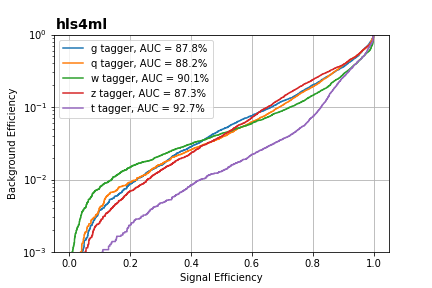

In [29]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

In [31]:
learningCurve(history)

C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


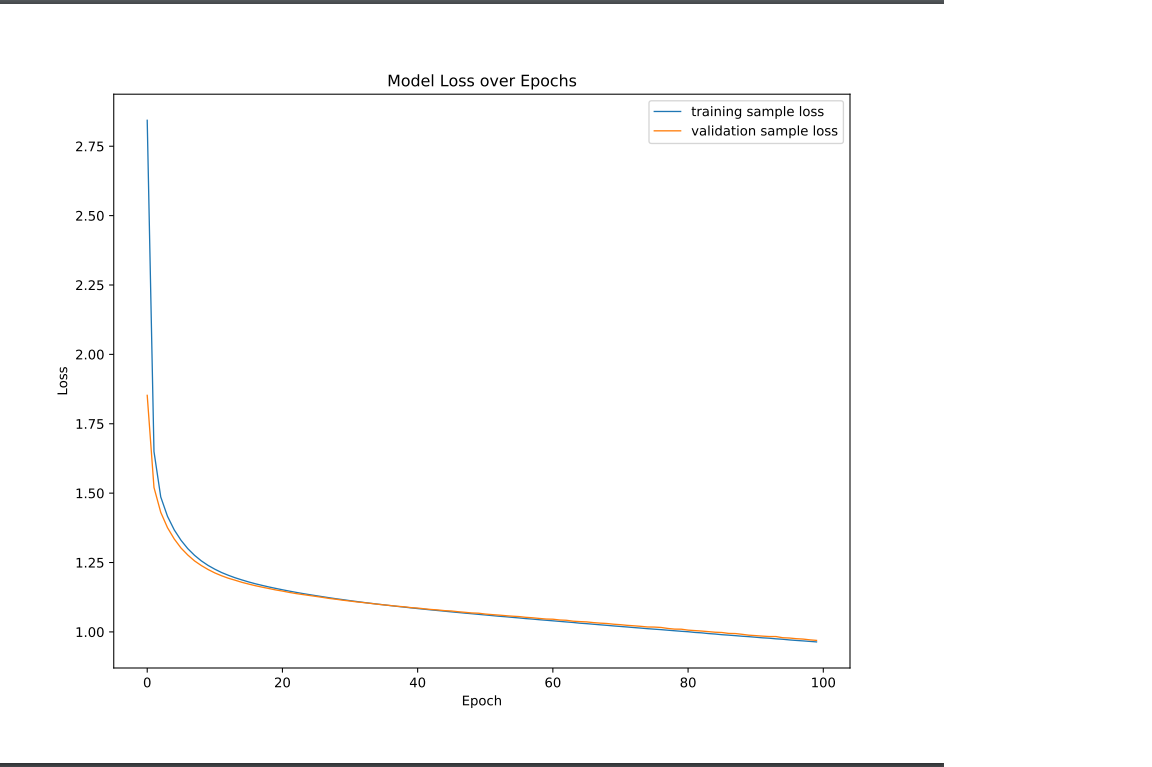